In [ ]:
#import bqplot
import datetime
import ee
import folium
import glob
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import os
import pandas as pd
import pprint
import pylab
import seaborn as sns
import json

from branca.colormap import linear
from branca.utilities import color_brewer
from collections import defaultdict

In [ ]:
corn_grain = pd.read_csv('./data/corn-grain.csv')

corn_grain_2018 = corn_grain[corn_grain['YEAR'] == 2018]
corn_grain_2018 = corn_grain_2018.groupby('STATE').mean().reset_index()
corn_grain_2018[['STATE', 'YIELD_BU_ACRE']]
corn_grain_2018['STATE'] = [state[0:2] for state in corn_grain_2018['STATE']]
corn_grain_2018.shape

In [3]:
for df in corn_grain.groupby('YEAR'):
    print(df)

(2011,        Unnamed: 0  YEAR      STATE  STATE_FIPS       COUNTY  COUNTY_FIPS  \
10560       12119  2011    ALABAMA           1      AUTAUGA            1   
10561       12120  2011    ALABAMA           1       DALLAS           47   
10562       12121  2011    ALABAMA           1       ELMORE           51   
10563       12122  2011    ALABAMA           1       GREENE           63   
10564       12123  2011    ALABAMA           1         HALE           65   
10565       12125  2011    ALABAMA           1      BALDWIN            3   
10566       12126  2011    ALABAMA           1     ESCAMBIA           53   
10567       12127  2011    ALABAMA           1       MONROE           99   
10568       12129  2011    ALABAMA           1   WASHINGTON          129   
10569       12130  2011    ALABAMA           1       BLOUNT            9   
10570       12131  2011    ALABAMA           1      CALHOUN           15   
10571       12132  2011    ALABAMA           1     CHEROKEE           19   
10572

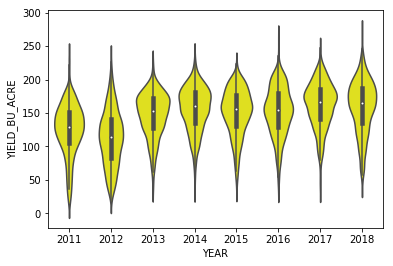

In [4]:
ax = sns.violinplot(x="YEAR", y="YIELD_BU_ACRE", data=corn_grain, color = 'yellow')

In [5]:
import pandas as pd

corn_grain = pd.read_csv('data/corn-grain.csv')

In [6]:
corn_grain['key_on'] = ['0500000US{:02d}{:03d}'.format(row.STATE_FIPS, row.COUNTY_FIPS) for row in corn_grain.itertuples()]

In [7]:
states = pd.read_csv('data/states.csv')

In [8]:
states.head()

State Abbreviation
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA

In [9]:
state_dict = {row.State.upper():row.Abbreviation for row in states.itertuples()}

In [10]:
corn_grain['STATE2'] = [state_dict[row.STATE] for row in corn_grain.itertuples()]

In [11]:
corn_grain.head()

Unnamed: 0  YEAR    STATE  STATE_FIPS   COUNTY  COUNTY_FIPS  ACRES_PLANTED  \
0           1  2018  ALABAMA           1  AUTAUGA            1           1100   
1           2  2018  ALABAMA           1   DALLAS           47           5400   
2           3  2018  ALABAMA           1   ELMORE           51           2200   
3           5  2018  ALABAMA           1    PERRY          105           6400   
4           6  2018  ALABAMA           1  BALDWIN            3           7200   

   ACRES_HARVESTED  YIELD_BU_ACRE          key_on STATE2  
0             1000          165.0  0500000US01001     AL  
1             5100          137.3  0500000US01047     AL  
2             2200          170.5  0500000US01051     AL  
3             6300          145.2  0500000US01105     AL  
4             7000          152.0  0500000US01003     AL

In [12]:
corn_pred_2019 = pd.read_csv('data/corn_pred_2019')

In [13]:
geo_path= 'data/shapefiles/us-states.json'

with open(geo_path, encoding='UTF-8') as json_file:
    geo_data = json.load(json_file)

In [14]:
# geo_path = 'data/shapefiles/us_counties_20m_topo.json'

# with open(geo_path, encoding='UTF-8') as json_file:
#     geo_data = json.load(json_file)

In [15]:
colormap = linear.YlGn_09.scale(0, corn_grain.YIELD_BU_ACRE.max())

print(colormap(5.0))

colormap

#feffdf


In [16]:
corn_by_state = corn_grain.groupby(['YEAR', 'STATE2']).agg('mean')
corn_by_state['idx'] = ['{}{}'.format(row.YEAR, row.STATE2) for row in corn_by_state.reset_index().itertuples()]
yield_dict_hist = defaultdict(int, corn_by_state.set_index('idx')['YIELD_BU_ACRE'])

In [17]:
corn_by_state = corn_pred_2019.groupby(['YEAR', 'STATE2']).agg('mean')
corn_by_state['idx'] = ['{}{}'.format(row.YEAR, row.STATE2) for row in corn_by_state.reset_index().itertuples()]
yield_dict_2019 = defaultdict(int, corn_by_state.set_index('idx')['YIELD_BU_ACRE'])

In [18]:
year = 2011
m = folium.Map([43, -100], zoom_start=4)

for year in range(2011, 2020):
    if year == 2019:
        show=True
        d = yield_dict_2019
        pred = '(Predicted)'
        
    else:
        show=False
        d = yield_dict_hist
        pred = ''
        
    
    folium.GeoJson(
        geo_data,
        name='Corn Yield {} {}'.format(pred, year),
        show=show,
        style_function=lambda feature: {
            'fillColor': colormap(d['{}{}'.format(year, feature['id'])]),
            'color': 'black',
            'weight': 1,
            'dashArray': '5, 5',
            'fillOpacity': 0.9,
        }
    ).add_to(m)

colormap.caption = 'Corn Yield (Bu/Acre)'
colormap.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

m.save(os.path.join('web/corn_yield_byStateAndYear.html'))

m

In [19]:
counties = json.load(open('data/shapefiles/us_counties_20m_topo.json'))

In [20]:
corn_grain['idx'] = ['{}{}'.format(row.YEAR, row.key_on) for row in corn_grain.reset_index().itertuples()]

In [21]:
yield_dict_county_hist = defaultdict(int, corn_grain.set_index('idx')['YIELD_BU_ACRE'])

In [26]:
yield_dict_county_2019 = defaultdict(int)
keys = ['2019{}'.format(key) for key in corn_pred_2019['key_on']]
for k, v in zip(keys, corn_pred_2019['YIELD_BU_ACRE']):
    yield_dict_county_2019[k] = v

In [27]:
def style_function(feature):
    return {
    'fillColor': colormap(d['{}{}'.format(year, feature['id'])]),
    'color': 'black',
    'dashArray': '5, 5',
    'weight':1,
    'fillOpacity': 0.9
    }

In [32]:
#2019 only
m = folium.Map([43, -100], zoom_start=4)
year=2019

show=True
d = yield_dict_county_2019
pred = '(Predicted)'        

folium.TopoJson(
    counties,
    'objects.us_counties_20m',
    name='Corn Yield {}'.format(year),
    style_function=style_function,
    show=show
).add_to(m)

    
colormap.caption = '2019 Predicted Corn Yield (Bu/Acre)'
colormap.add_to(m)

m.save(os.path.join('web', 'yield_choropleth_counties.html'))

m

In [28]:
m = folium.Map([43, -87], zoom_start=4)
year=2018


for year in range(2018, 2020):
    if year == 2019:
        show=True
        d = yield_dict_county_2019
        pred = '(Predicted)'
        
    else:
        show=False
        d = yield_dict_county_hist
        pred = ''
        
    
    folium.TopoJson(
        counties,
        'objects.us_counties_20m',
        name='Corn Yield {}'.format(year),
        style_function=style_function,
        show=show
    ).add_to(m)

    
colormap.caption = 'Corn Yield (Bu/Acre)'
colormap.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

m.save(os.path.join('web', 'yield_choropleth_counties.html'))

m

In [34]:
corn_pred_2019['YIELD_BU_ACRE'].mean()

150.29613353185678

In [35]:
sum(y*a for y,a in zip(corn_pred_2019['YIELD_BU_ACRE'], corn_pred_2019['ACRES_PLANTED']))

12505156469.217684